In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from helpers import generate_embedding
from graph_role_extraction import find_k_clusters, find_optimal_clusters, HellingerPCs

# Data

The LOTR character concurrence network data along with node metadata is included in the repository.

In [11]:
node_data = pd.read_csv('node_data.txt', sep='\t')

G = nx.Graph()
for i in range(len(node_data)):
    G.add_node(node_data['node_id'][i], name = node_data['name'][i])

edge_data = pd.read_csv('LOTR_edgelist.txt', sep=' ', header=None, names=["source", "target", "weight"])

for i in range(len(edge_data)):
    G.add_edge(edge_data['source'][i], edge_data['target'][i], weight = edge_data['weight'][i])

N = len(G.nodes)
positions = nx.forceatlas2_layout(G)

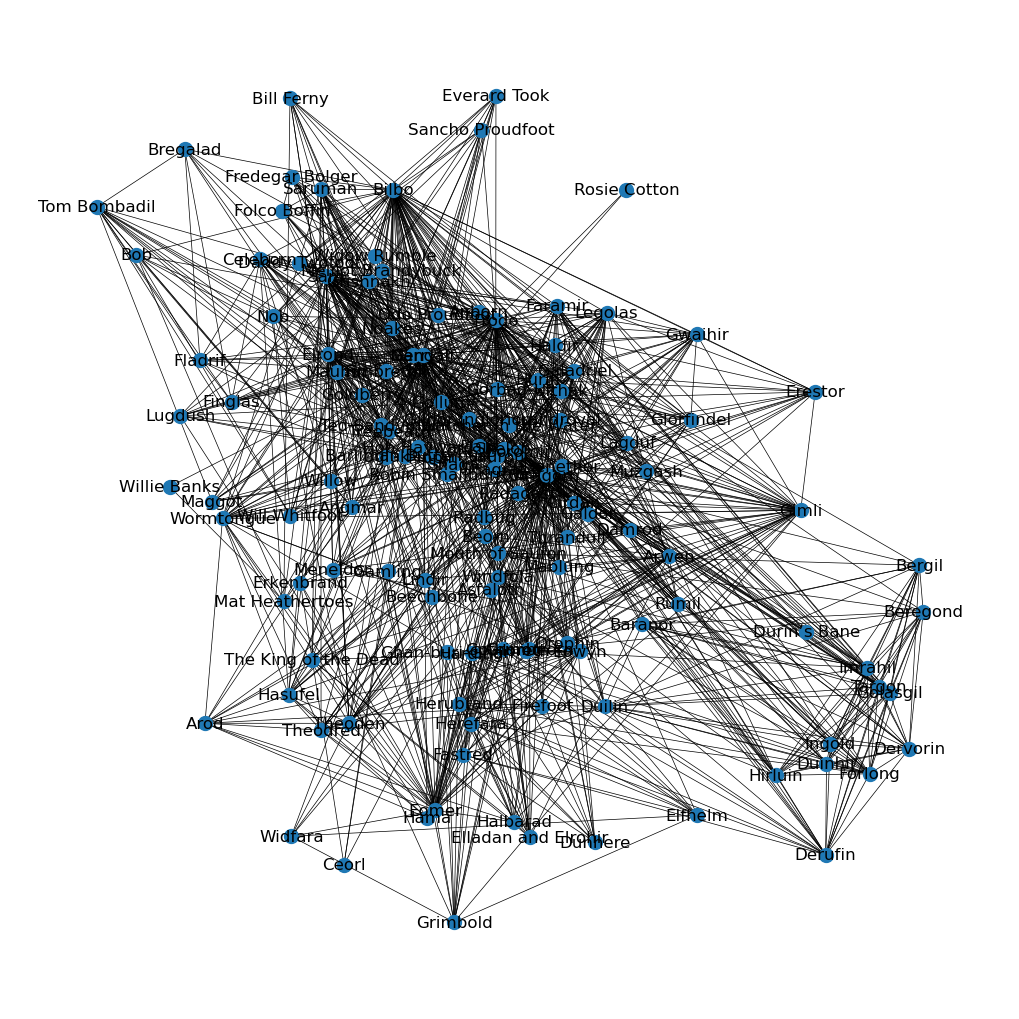

In [13]:
fig=plt.figure(figsize=(10, 10))
nx.draw(G, pos = positions, node_size=100, width=0.5, with_labels=True, labels= dict(G.nodes('name')))

In [15]:
import community as community_louvain
def detect_communities(graph):
    # Apply Louvain community detection algorithm
    partition = community_louvain.best_partition(graph, resolution=1)
    return partition

#coms = detect_communities(G)

coms_ = nx.community.louvain_communities(G, weight='weight', resolution=0.7)

from collections import defaultdict
def partition_dict_to_list(partition_dict):
    community_map = defaultdict(set)
    
    for node, community in partition_dict.items():
        community_map[community].add(node)
    
    return list(community_map.values())

def partition_list_to_dict(partition_list):
    community_map = {}
    for i in range(len(partition_list)):
        for j in partition_list[i]:
            community_map[j] = i
    return dict(sorted(community_map.items()))

coms = partition_list_to_dict(coms_)

nx.community.modularity(G, coms_)

0.1752310076524242

In [17]:
len(coms_)

3

In [19]:
embedding = generate_embedding(G=G, M=120, teleport=False, alpha=0.1, normalise_embedding=True)
pca = HellingerPCs(embedding, n_components=15)
clusters, roles, group_to_nodes = find_k_clusters(HellingerPC=pca, n_clusters=3)

Text(0, 0.5, 'Principal component 2 (Hellinger)')

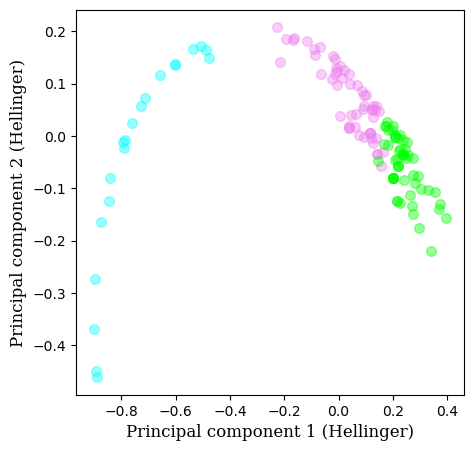

In [22]:
fig = plt.figure(figsize=(5, 5))
# Generate colors for each community
uniqs = np.unique(list(coms.values()))
colors = ['lightblue', 'lightgreen', 'lightpink', 'orange']
node_colors_coms = [colors[coms[node]] for node in G.nodes()]

uniqs = np.unique(clusters)
#colors = [plt.cm.jet(i / len(uniqs)) for i in range(len(uniqs))]
colors = ['lime', 'cyan', 'violet']
node_colors = [colors[roles[node]] for node in G.nodes()]



for i in range(N):
    plt.plot(pca[i, 0], pca[i, 1], color=node_colors[i], marker='o', markersize=7, alpha=0.4)

#plt.title('PCA')
plt.xlabel('Principal component 1 (Hellinger)', font='serif', fontsize=12) ; plt.ylabel('Principal component 2 (Hellinger)', fontsize=12, font='serif')

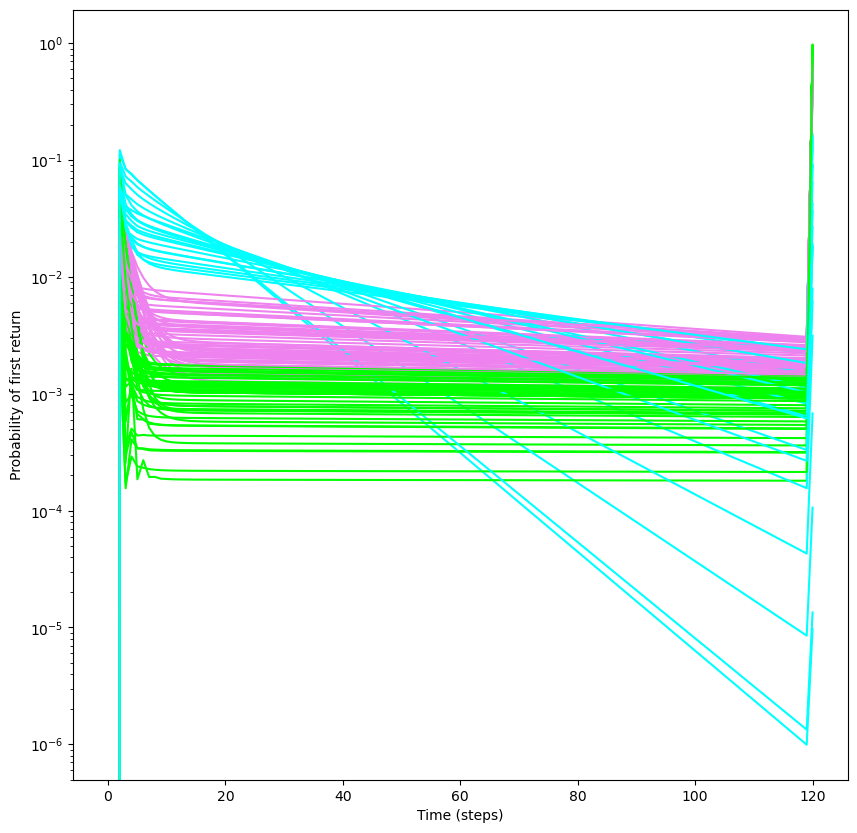

In [24]:
fig = plt.figure(figsize=(10, 10))
for i in range(N):
    plt.plot(embedding[i], color=node_colors[i])

plt.xlabel('Time (steps)')
plt.ylabel('Probability of first return')

plt.yscale('log')

In [34]:
edge_widths=[]
for edge in G.edges:
    edge_widths.append(G.edges[edge]['weight']/40)

In [36]:
labels = {}
for i in range(len(G.nodes)):
    if roles[i] == 1:
        labels[i] = G.nodes[i]['name']
    else:
        labels[i] = ''

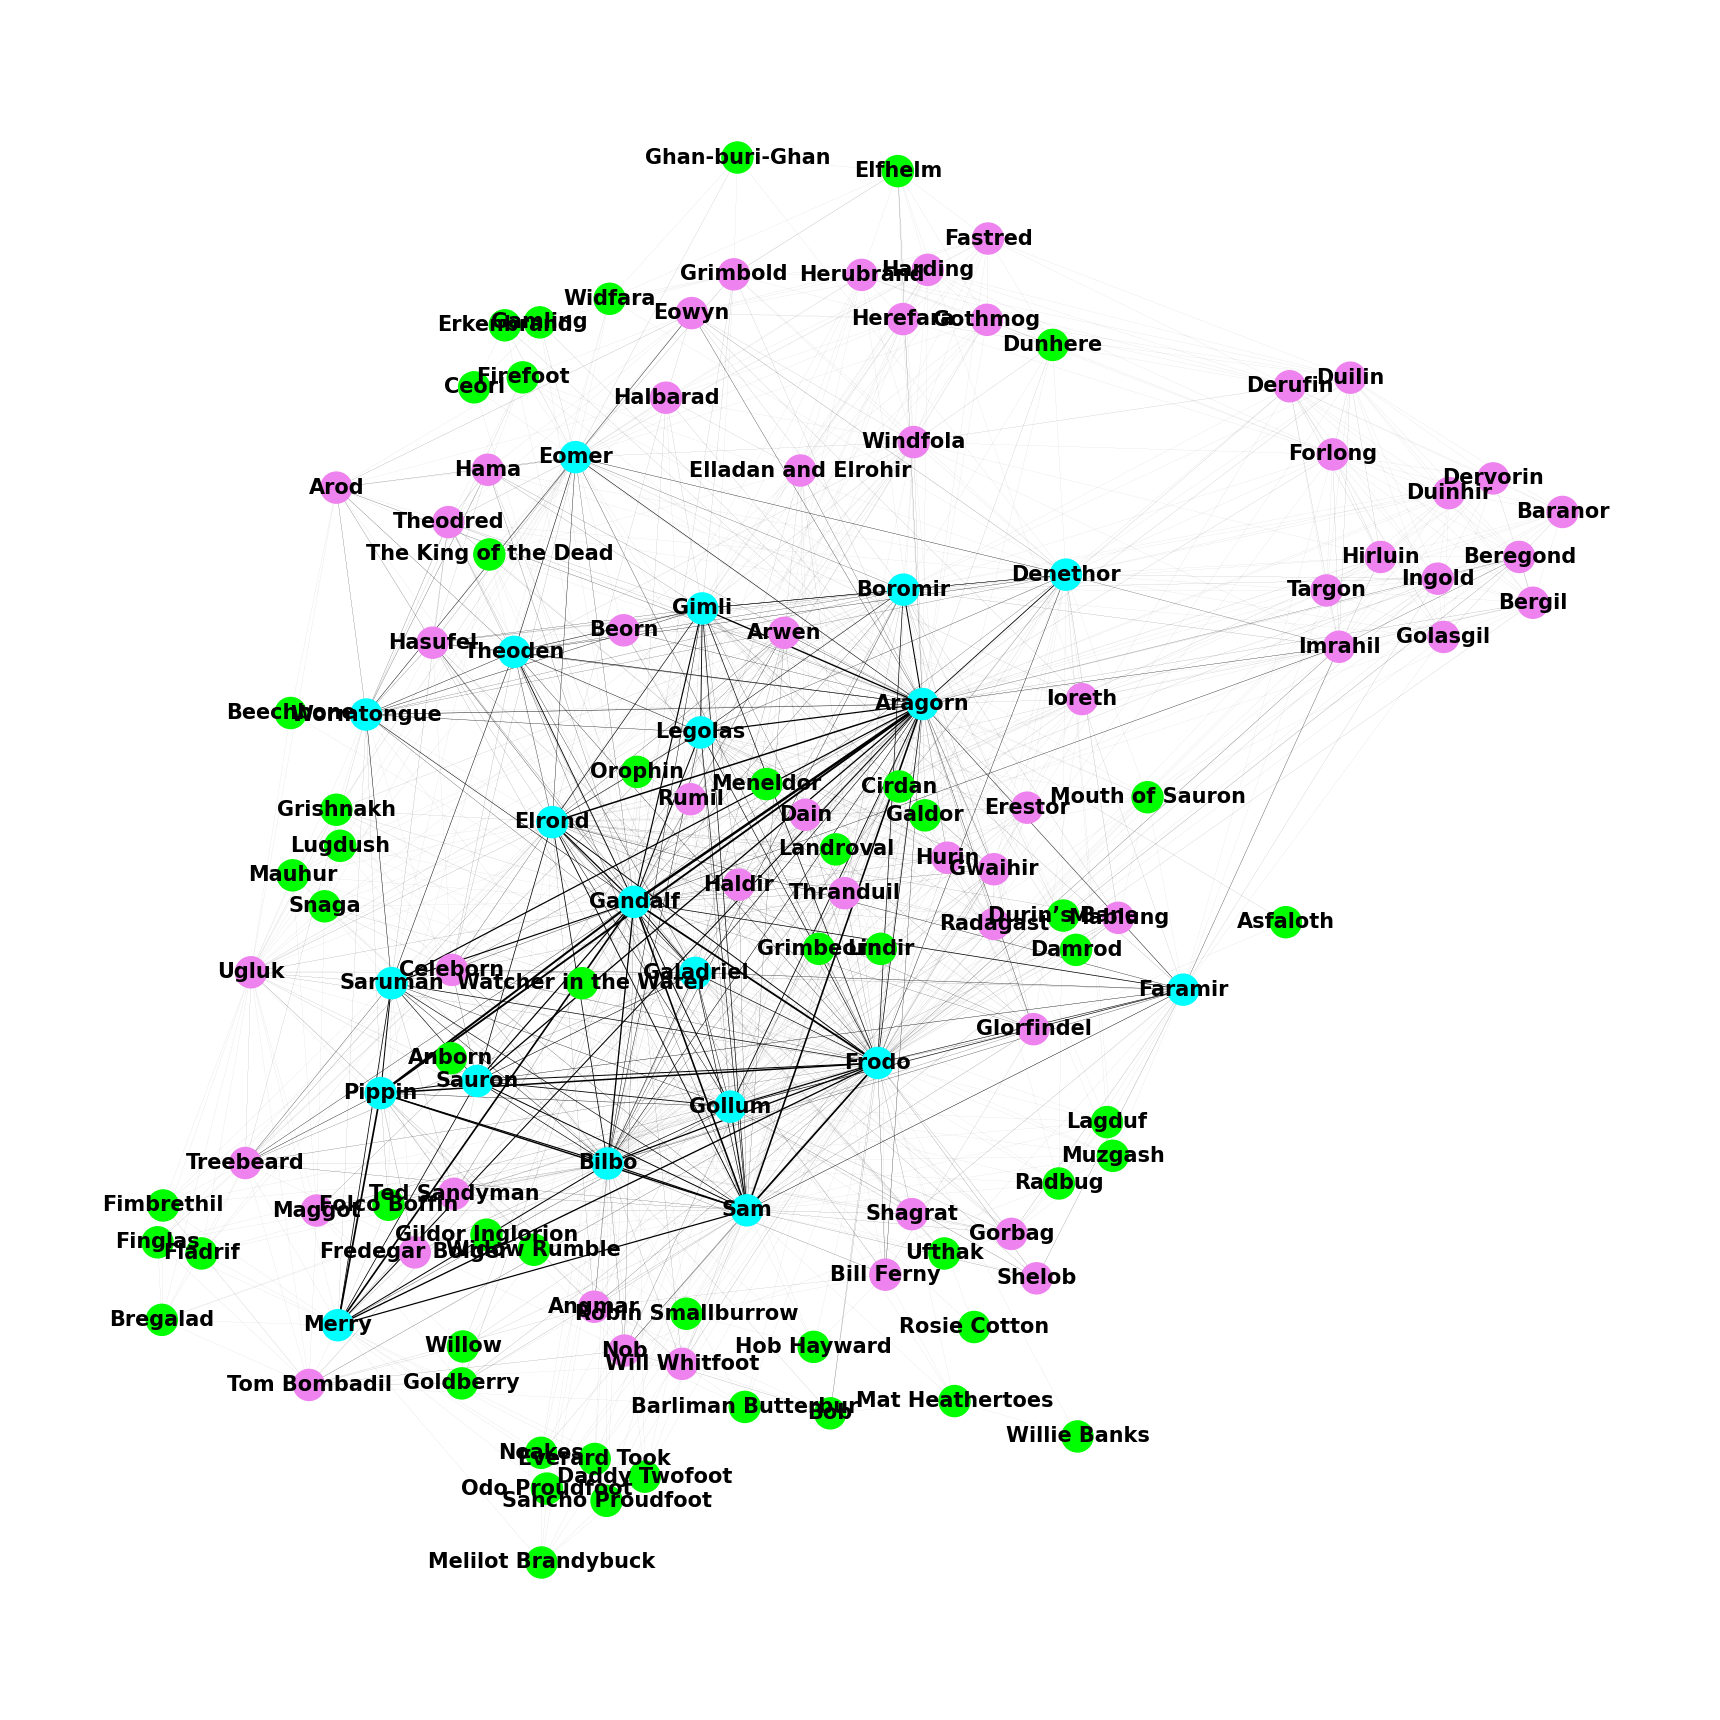

In [42]:
positions = nx.forceatlas2_layout(G, weight=None, scaling_ratio=2)
fig = plt.figure(figsize=(17, 17))
nx.draw(G, pos=positions, node_color=node_colors, labels=dict(G.nodes('name')), width=edge_widths, node_size=500, alpha=1, font_color='k'
       , font_weight='bold', with_labels=False)

fi = nx.draw_networkx_labels(G, pos=positions, 
                        labels=dict(G.nodes('name')),
                        font_color="black",
                        font_weight="bold", font_size=15)